In [43]:
import re
import random
import pandas as pd
import hashlib

In [44]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [45]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,290.029801,32.225533,49.292816,9
CCH Axcess,322.655986,11.126068,23.222034,29
"Jane Eyre, Bronte",474.382231,67.768890,160.926822,7
DAX,485.338494,53.926499,134.836171,9
Logging in Python,595.145232,74.393154,211.733724,8
Azure Private DNS,750.181417,83.353491,186.110379,9
Terraform,992.161478,82.680123,265.450837,12
Azure AD Authentication,1150.264910,95.855409,154.404580,12
Microsoft Purview,1236.661140,25.763774,44.516299,48
Azure Functions + PP365,1329.116679,83.069792,240.627440,16


# Histogram

sum of ages: ~49787.30


<Axes: >

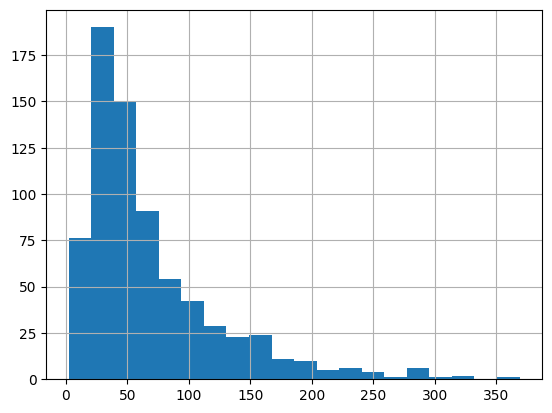

In [46]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~49787.30


<Axes: >

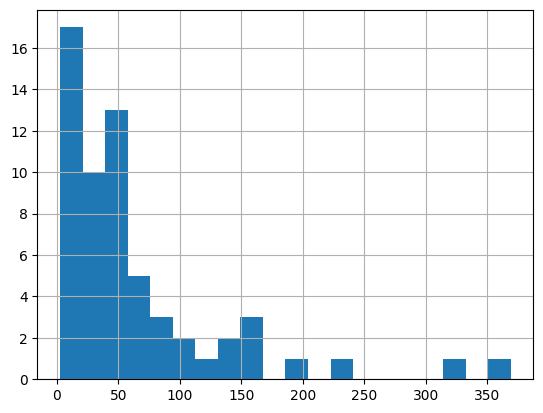

In [47]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [48]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [49]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [50]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [51]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [52]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [53]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [54]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [55]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [56]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [57]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 726
Total card age: 49787.30


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
165,Azure Developer Associate,You need to deploy an Azure Files share along ...,932245130addc67369d5402942504c81,369.109123,64.603325,-369.109123,3876.199523,0.714335,60,0,0,-369.109123
166,Azure Developer Associate,You need to implement an Azure Storage lifecyc...,bf1b728607b958c3e992b65a2597c2b2,193.971383,64.603325,-369.109123,3876.199523,0.714335,60,3,0,-193.971383
167,Azure Developer Associate,Each Azure App Configuration feature flag has ...,b51e193a67245c87d639e62d53f97e1c,151.716942,64.603325,-369.109123,3876.199523,0.714335,60,6,0,-151.716942
168,Azure Developer Associate,Keys serve as the name for key-value pairs and...,8a0c6434b2d4cb2de93f5701d87e9902,113.181721,64.603325,-369.109123,3876.199523,0.714335,60,9,0,-113.181721
169,Azure Developer Associate,Multi-container groups currently support only ...,3236205e681f22f135376b9a1402fca5,92.246898,64.603325,-369.109123,3876.199523,0.714335,60,12,0,-92.246898
170,Azure Developer Associate,This item tests the candidate's knowledge abou...,6fe79337b4deb9fb686475b63ef2eaaa,71.112325,64.603325,-369.109123,3876.199523,0.714335,60,15,0,-71.112325
654,Azure Developer Associate,"In Read and Delete mode, Service Bus receives ...",0d0d551c38b7482b5aca8d90bb7ff41e,58.268844,64.603325,-369.109123,3876.199523,0.714335,60,18,0,-58.268844
172,Azure Developer Associate,"As a solution architect/developer, you should ...",af9084158966068a8a52da855ee15df7,52.930222,64.603325,-369.109123,3876.199523,0.714335,60,21,0,-52.930222
655,Azure Developer Associate,Azure supports two types of queue mechanisms: ...,080d708c96d5b86789ba25db318387a7,49.392559,64.603325,-369.109123,3876.199523,0.714335,60,24,0,-49.392559
174,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,e5ab4ca6cb91b93cef8541fbf2a71637,47.245802,64.603325,-369.109123,3876.199523,0.714335,60,27,0,-47.245802


## Card Count

In [58]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [59]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [60]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
165,Azure Developer Associate,You need to deploy an Azure Files share along ...,932245130addc67369d5402942504c81,369.109123,64.603325,-369.109123,3876.199523,0.714335,60,0,0,-369.109123
408,Azure Developer Associate,A company has an App Service web app that requ...,786eb611c1ad4b131a5b90871a4e2fd8,331.985405,64.603325,-369.109123,3876.199523,0.714335,60,1,1,-331.985405
59,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,330.751381,87.429767,-330.751381,2622.893013,0.606480,30,0,0,-330.751381
69,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,305.825394,86.883636,-305.825394,2693.392704,0.628125,31,0,0,-305.825394
46,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,291.068117,87.345753,-291.068117,3319.138606,0.455773,38,0,0,-291.068117
10,Azure DevOps Pipelines,What is the default working directory for a pi...,4874a140413af48140b5cb984340bd62,288.837927,98.721224,-288.837927,1579.539576,0.883251,16,0,0,-288.837927
260,Azure DevOps Pipelines,How can you pass secrets securely in Azure Dev...,5b00153ed3bdf8955aa08ad4e2779a5c,283.457394,98.721224,-288.837927,1579.539576,0.883251,16,1,1,-283.457394
295,Asynchronous Python,async with (async context manager)\nManages as...,359a45c84a774bead164891fd0454b3c,281.754083,87.345753,-291.068117,3319.138606,0.455773,38,1,1,-281.754083
185,Python,Q:\nWhich itertools function can be used to cr...,e10c94072687976e9627c8fc187d9ea3,279.322860,55.320941,-279.322860,2932.009867,0.740903,53,0,0,-279.322860
37,PowerShell Modules,Find-Module\n\nDefinition: Searches for module...,4441d462ea754e1bb6a659efa359382f,278.479226,89.489783,-278.479226,2416.224128,0.523816,27,0,0,-278.479226


In [61]:
existing_cards['age'].mean()

68.57754666549506